# Preliminary analysis of human mobility subflows and parking data

In [1]:
import pandas as pd
import numpy as np
import os

from scipy.stats import pearsonr

import matplotlib.pyplot as plt
%matplotlib inline

##  Zone 1

### July

In [2]:
def read_parking_data_fn(path):
    zone = pd.read_csv(path, sep=';', parse_dates=['recvTime'], index_col='recvTime')
    return zone

In [3]:
zone1 = read_parking_data_fn(os.path.join('data', 'parkings_JULIO', 'zone1.csv'))

In [4]:
zone1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 446 entries, 2020-07-13 10:00:00 to 2020-07-31 23:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   free    446 non-null    float64
dtypes: float64(1)
memory usage: 7.0 KB


In [5]:
zone1.head()

,free
recvTime,
2020-07-13 10:00:00,167.363636
2020-07-13 11:00:00,246.157895
2020-07-13 12:00:00,351.465909
2020-07-13 13:00:00,404.080000
2020-07-13 14:00:00,362.413238


#### Read mobility subflows (resampled)

In [6]:
time_period= 'july'

In [7]:
def read_clean_flows_fn(target_time_period):
    subflows= {}
    for c in range(6,11):
        df = pd.read_csv(os.path.join('data', 'INE_subflows','flow_criterion_{}_clean_{}.csv'.format(c, target_time_period)),
                       parse_dates=[0], index_col=0)
        subflows[c] = df
    return subflows

In [8]:
subflows_resampled = read_clean_flows_fn(time_period)

In [9]:
subflows_resampled[6].head()

,n_viajes_old,n_viajes
2020-07-01 00:00:00,5.219,5.219000
2020-07-01 01:00:00,5.219,5.219000
2020-07-01 02:00:00,NaN,6.855667
2020-07-01 03:00:00,NaN,8.492333
2020-07-01 04:00:00,10.129,10.129000


In [10]:
subflows_resampled[6].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 744 entries, 2020-07-01 00:00:00 to 2020-07-31 23:00:00
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   n_viajes_old  570 non-null    float64
 1   n_viajes      744 non-null    float64
dtypes: float64(2)
memory usage: 17.4 KB


#### Global plot

In [11]:
def plot_global_plot_fn(parking_data, subflows):
    
    target_days = parking_data.index
    ax= parking_data.plot(figsize=(20,5), label='Free places', color='blue')

    ax2 = ax.twinx()
    ax2.spines['right'].set_position(('axes', 1.0))

    subflows[6].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, label='crit.6', color='orange')
    subflows[7].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, label='crit.7', color='green')
    subflows[8].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, label='crit.8', color='purple')
    subflows[9].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, label='crit.9', color='red')
    subflows[10].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, label='crit.10', color='yellow')


    ax.set_ylabel('Free places in parking')
    ax2.set_ylabel('Num of trips');

    ax.yaxis.label.set_color('blue')
    ax2.yaxis.label.set_color('red')

    ax.tick_params(axis='y', colors='blue')
    ax2.tick_params(axis='y', colors='red')

    leg = ax.legend(loc='center', bbox_to_anchor=(0.5, -0.10), shadow=False, ncol=2)
    leg = ax2.legend(loc='center', bbox_to_anchor=(0.7, -0.10), shadow=False, ncol=5)

    plt.show()

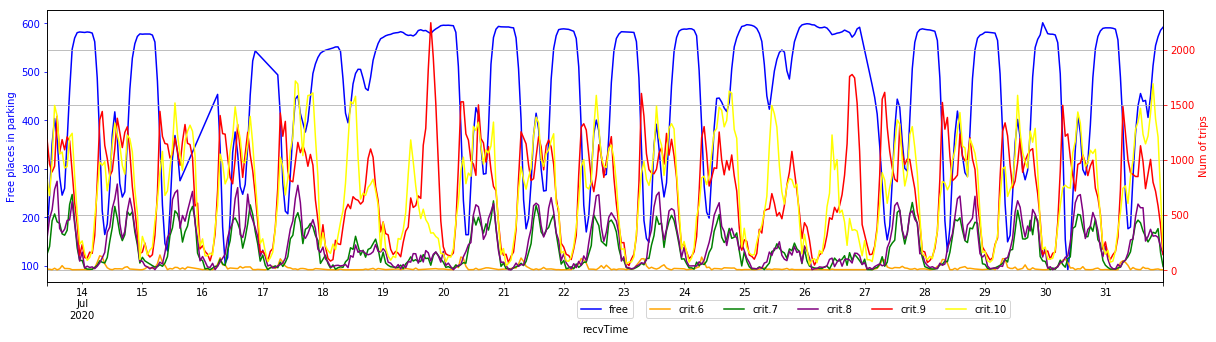

In [12]:
plot_global_plot_fn(zone1, subflows_resampled)

#### Side by side plot

In [13]:
def plot_side_by_side_fn(parking_data, subflows):
    target_days = parking_data.index

    f, axes = plt.subplots(5, 1, figsize=(20,10), sharey='row', sharex='col')
    axe = axes.ravel()
    i=0
    for c in range(6,11):
        parking_data.plot(ax= axe[i], color='blue', title='Parking places vs subflow criterion {}'.format(c))
        ax2 = axe[i].twinx()
        ax2.spines['right'].set_position(('axes', 1.0))

        subflows[c].loc[target_days]['n_viajes'].plot(ax=ax2, grid=True, color='red')

        axe[i].set_ylabel('Free places')
        ax2.set_ylabel('Num. trips')
        axe[i].yaxis.label.set_color('blue')
        ax2.yaxis.label.set_color('red')

        axe[i].tick_params(axis='y', colors='blue')
        ax2.tick_params(axis='y', colors='red')

        i +=1

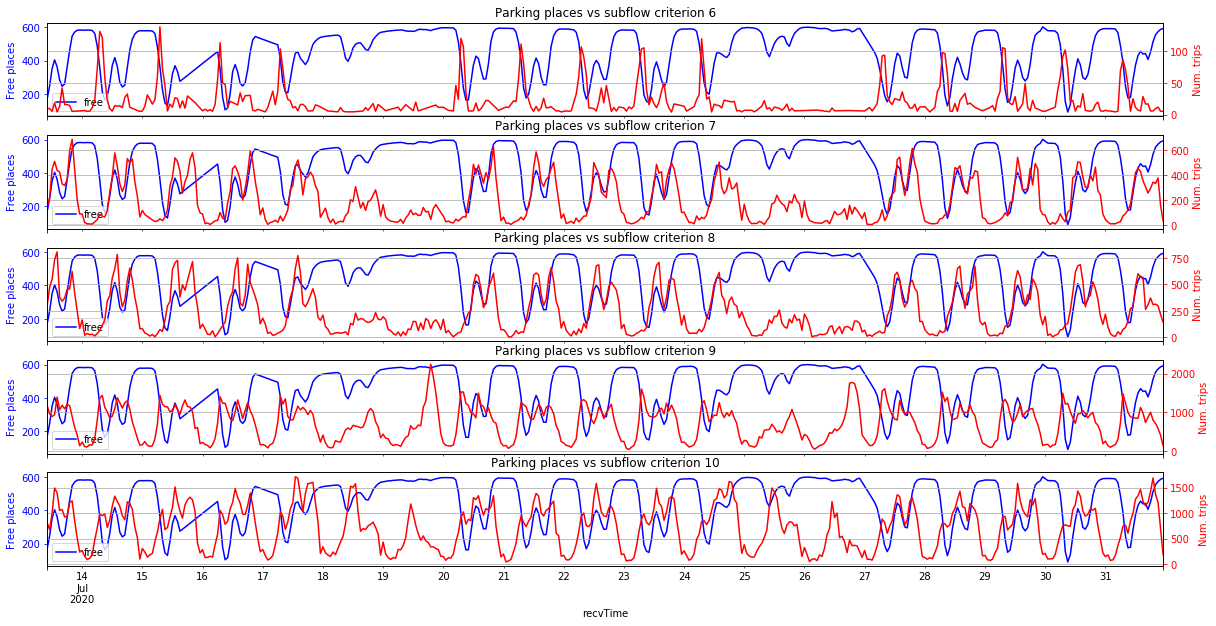

In [14]:
plot_side_by_side_fn(zone1, subflows_resampled)

#### Correlation analysis

Pearson correlation

In [15]:
def calculate_correlations_fn(parking_data, subflows):
    corr_={}
    # We just keep with the non-null values of the time series
    parking_no_nan = parking_data.dropna()
    new_target_days = parking_no_nan.index
    for c in range(6,11):
        r, p= pearsonr(subflows[c].loc[new_target_days]['n_viajes'], parking_no_nan['free'])
        corr_[c]= {'pearsonr': r, 'p-val': p}
    #print(f"Criterion {c}: Scipy computed Pearson r: {r} and p-value: {p}")
    return corr_

In [16]:
correlations_july = calculate_correlations_fn(zone1, subflows_resampled)

In [17]:
for c in correlations_july:
    print(f"Criterion {c}: Scipy computed Pearson r: {correlations_july[c]['pearsonr']} and p-value: {correlations_july[c]['p-val']}")

Criterion 6: Scipy computed Pearson r: -0.4284228712122882 and p-value: 2.4588160407820637e-21
Criterion 7: Scipy computed Pearson r: -0.265508173442849 and p-value: 1.2412050438899909e-08
Criterion 8: Scipy computed Pearson r: -0.34170204226067036 and p-value: 1.1660702573953624e-13
Criterion 9: Scipy computed Pearson r: -0.6419704119519497 and p-value: 3.5498782461462606e-53
Criterion 10: Scipy computed Pearson r: -0.5019063123328634 and p-value: 7.80364533221181e-30


Time-lagged cross correlation

In [18]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

In [19]:
def plot_cross_correlation_fn(parking_data,subflows):
    f, axes = plt.subplots(5, 1, figsize=(20,10), sharey='row', sharex='col')
    axe = axes.ravel()
    i=0
    for c in subflows:
        rs = [crosscorr(parking_data['free'], subflows[c]['n_viajes'], lag) for lag in range(-14,14)]
        offset = np.ceil(len(rs)/2)-np.argmax(rs)
        #f,ax=plt.subplots(figsize=(14,3))
        axe[i].plot(rs)
        #axe[i].axvline(0,color='k',linestyle='--',label='Center')
        axe[i].axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
        axe[i].set(title=f'Offset criterion {c} = {offset} hours\nParking leads <> Subflow leads',ylim=[-1,1],xlim=[0,24], ylabel='Pearson r')
        axe[i].set_xticks(np.arange(0,28))
        axe[i].set_xticklabels(np.arange(-14,14));
        axe[i].grid(True)
        i += 1
    axe[i-1].set(xlabel='Offset (in days)')
    plt.subplots_adjust(hspace=0.5)

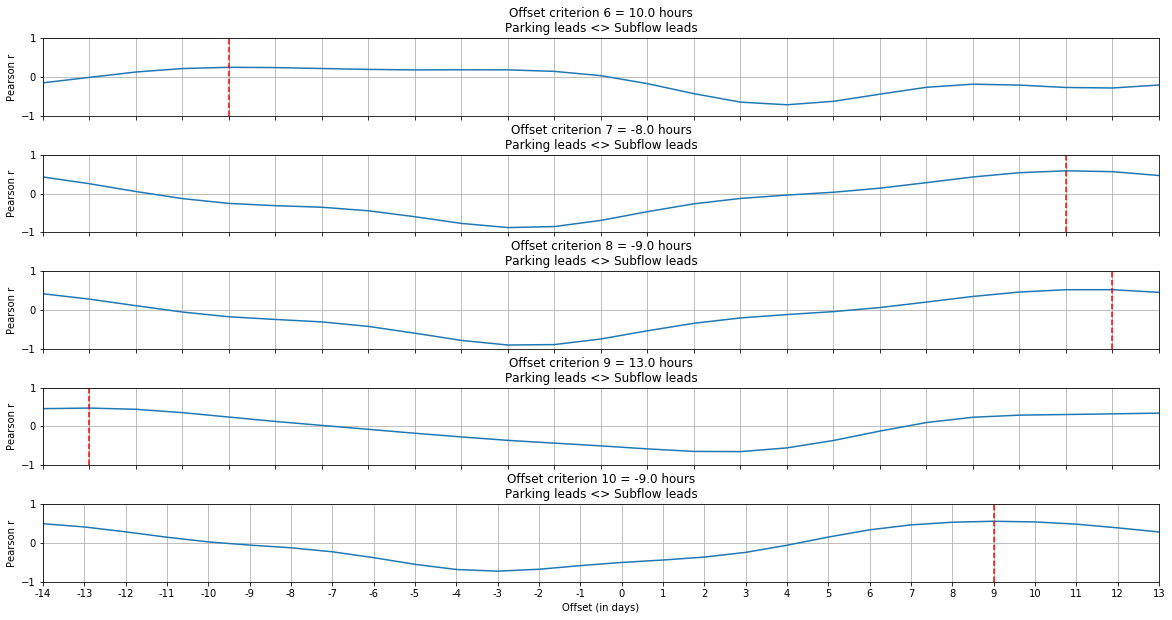

In [20]:
plot_cross_correlation_fn(zone1, subflows_resampled)

### Sept-Oct.

In [21]:
time_period= 'sept_oct' # or 'july'

In [22]:
zone1 = read_parking_data_fn(os.path.join('data', 'parkings_SEPT_OCT', 'zone1.csv'))
zone1.head()

,free
recvTime,
2020-09-29 09:00:00,175.913876
2020-09-29 10:00:00,203.244361
2020-09-29 11:00:00,284.338346
2020-09-29 12:00:00,371.956522
2020-09-29 13:00:00,412.063636


In [23]:
subflows_resampled = read_clean_flows_fn(time_period)

#### Global plot

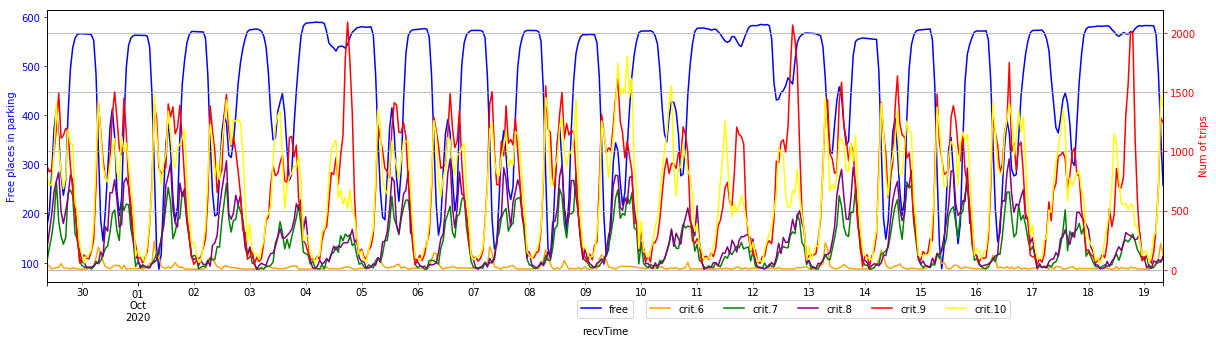

In [24]:
plot_global_plot_fn(zone1, subflows_resampled)

#### SIde-by-side plot

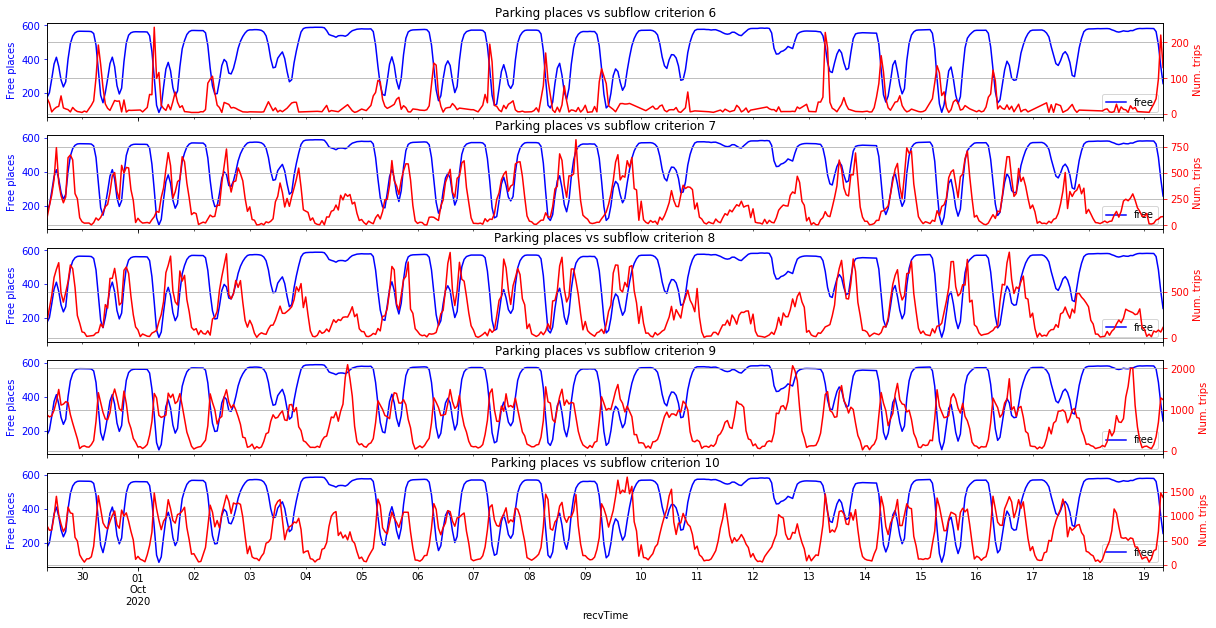

In [25]:
plot_side_by_side_fn(zone1, subflows_resampled)

#### Correlation analysis

Pearson correlation

In [26]:
correlations_sept_oct = calculate_correlations_fn(zone1, subflows_resampled)

In [27]:
for c in correlations_sept_oct:
    print(f"Criterion {c}: Scipy computed Pearson r: {correlations_sept_oct[c]['pearsonr']} and p-value: {correlations_sept_oct[c]['p-val']}")

Criterion 6: Scipy computed Pearson r: -0.3920892173945837 and p-value: 4.344313582375112e-19
Criterion 7: Scipy computed Pearson r: -0.31352343244096925 and p-value: 2.0795900678429143e-12
Criterion 8: Scipy computed Pearson r: -0.3372769859301761 and p-value: 3.108105245252521e-14
Criterion 9: Scipy computed Pearson r: -0.6519894749813195 and p-value: 1.9537125537173625e-59
Criterion 10: Scipy computed Pearson r: -0.6383757055555224 and p-value: 2.654664153862253e-56


Time-lagged correlation

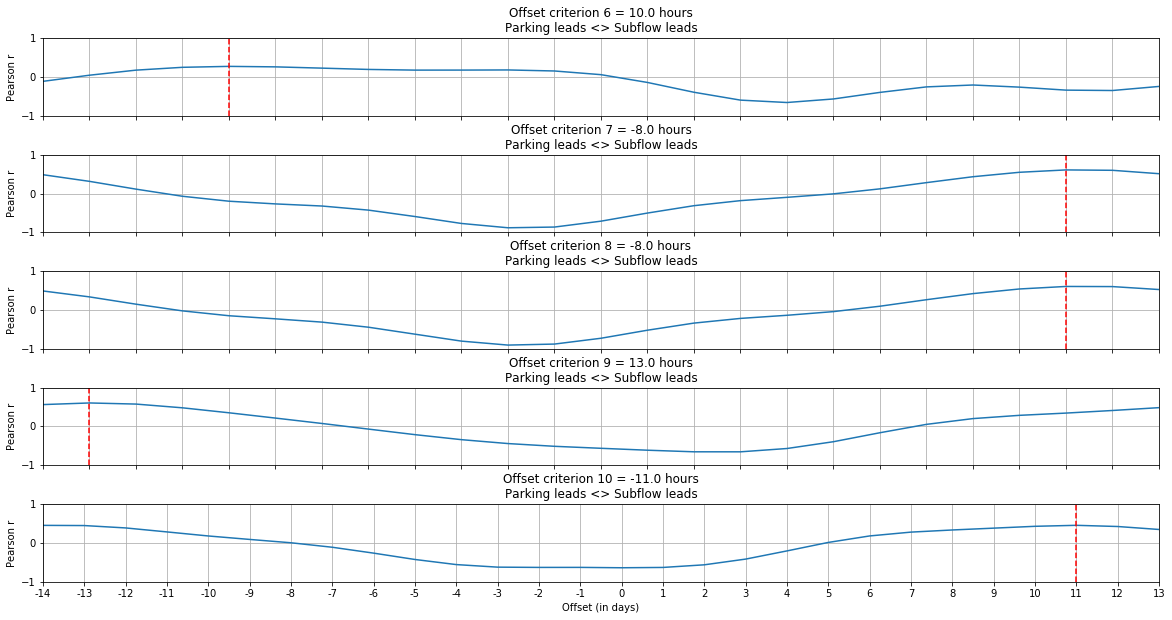

In [28]:
plot_cross_correlation_fn(zone1, subflows_resampled)

### Compare correlations (july vs sept-oct)

In [29]:
for c in correlations_sept_oct:
    print(f"Criterion {c}: Corr. (july): {correlations_july[c]['pearsonr']}, Corr. (sept-oct): {correlations_sept_oct[c]['pearsonr']}")

Criterion 6: Corr. (july): -0.4284228712122882, Corr. (sept-oct): -0.3920892173945837
Criterion 7: Corr. (july): -0.265508173442849, Corr. (sept-oct): -0.31352343244096925
Criterion 8: Corr. (july): -0.34170204226067036, Corr. (sept-oct): -0.3372769859301761
Criterion 9: Corr. (july): -0.6419704119519497, Corr. (sept-oct): -0.6519894749813195
Criterion 10: Corr. (july): -0.5019063123328634, Corr. (sept-oct): -0.6383757055555224


## Zone 2

### July

In [30]:
zone2 = read_parking_data_fn(os.path.join('data', 'parkings_JULIO', 'zone2.csv'))

In [31]:
time_period= 'july'

In [32]:
subflows_resampled = read_clean_flows_fn(time_period)

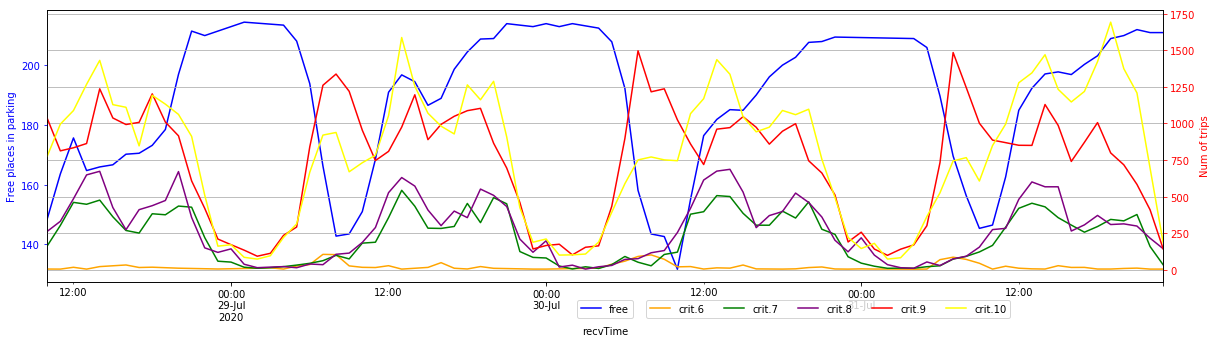

In [33]:
plot_global_plot_fn(zone2, subflows_resampled)

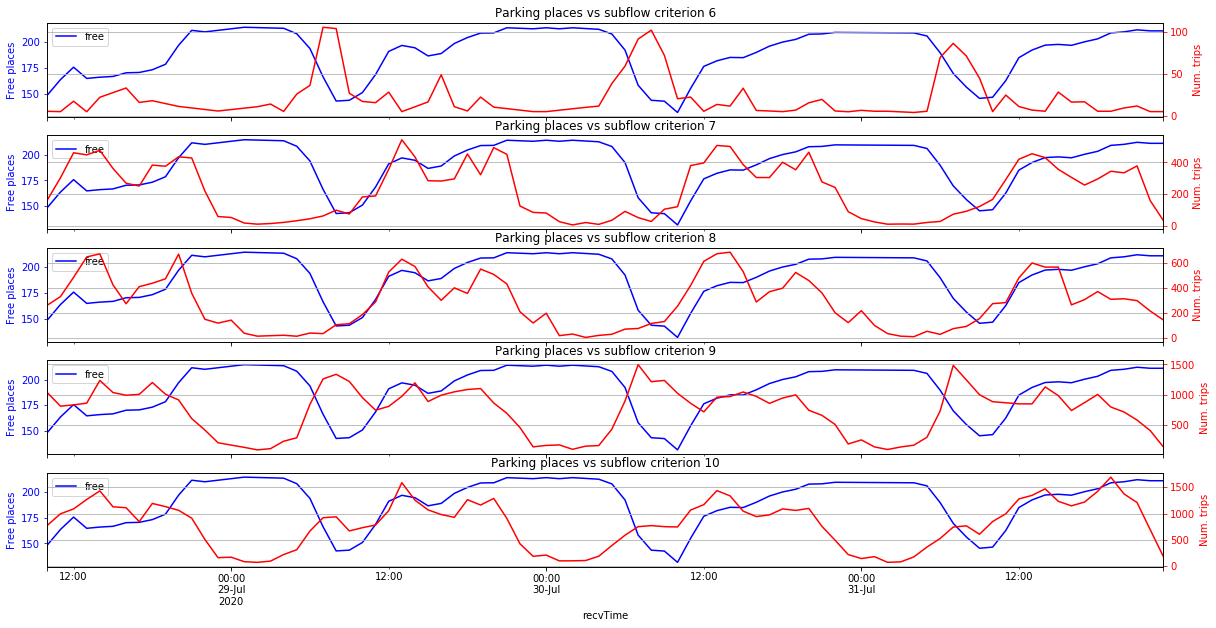

In [34]:
plot_side_by_side_fn(zone2, subflows_resampled)

In [35]:
correlations_july= calculate_correlations_fn(zone2, subflows_resampled)
for c in correlations_july:
    print(f"Criterion {c}: Scipy computed Pearson r: {correlations_july[c]['pearsonr']} and p-value: {correlations_july[c]['p-val']}")

Criterion 6: Scipy computed Pearson r: -0.5343225932957222 and p-value: 1.1666358338068705e-07
Criterion 7: Scipy computed Pearson r: -0.07747127587116882 and p-value: 0.47832900695354935
Criterion 8: Scipy computed Pearson r: -0.13078720640089134 and p-value: 0.23002819895912752
Criterion 9: Scipy computed Pearson r: -0.7051858092750416 and p-value: 3.472815481534823e-14
Criterion 10: Scipy computed Pearson r: -0.324086079992801 and p-value: 0.0023339217489464115


From the correlation values flows 6 and 9 seem the two most promising ones

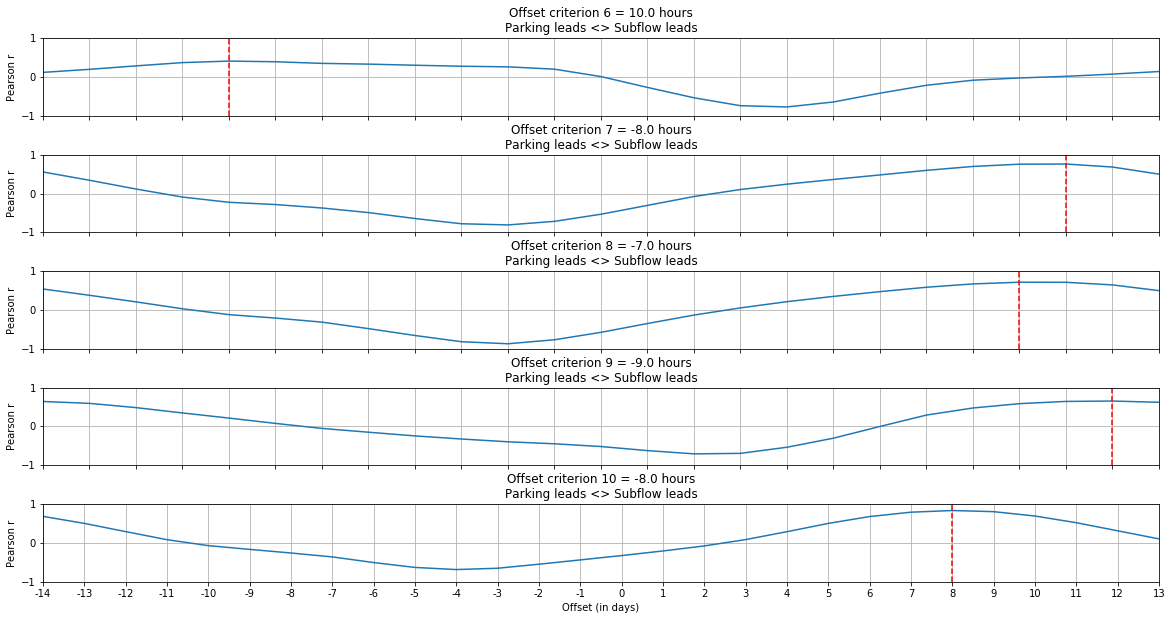

In [36]:
plot_cross_correlation_fn(zone2, subflows_resampled)

In [37]:
print("That's all folks!")

That's all folks!
